<a href="https://colab.research.google.com/github/panicoro/FS-process-image/blob/master/Entrega_P%C5%95actica_1_Pablo_Rosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


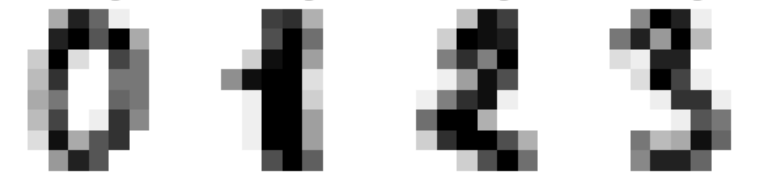



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

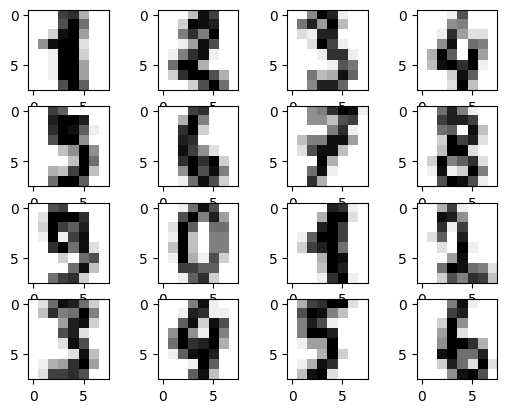

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))

# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [ ]:
# Cargo los dígitos
#X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y==1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = \
  train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de clases para clasificacion entre 10 dígitos:",
      str(np.bincount(y_train)))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] -
                                                       y_bin_test.sum()))

Total de datos para clasificación entre 10 dígitos: 1797
Total de clases para clasificacion entre 10 dígitos: [123 127 125 127 117 109 124 117 122 112]
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

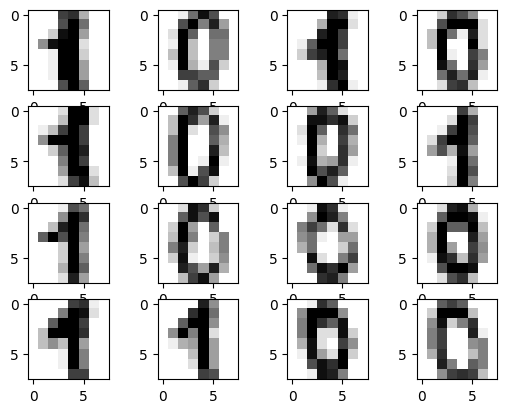

In [ ]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

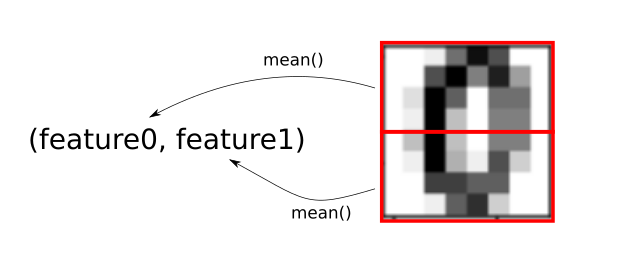

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

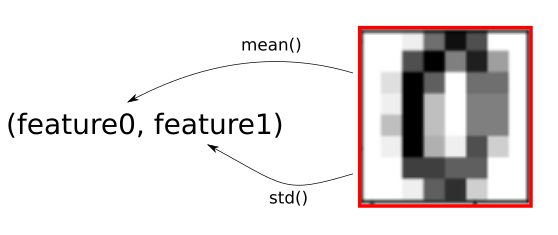


In [ ]:
def extract_features_mean_std(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = x.mean()
  x_out[0,1] = x.std()
  return x_out


def extract_features_mean_top_bottom(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = x[0:4, :].mean()
  x_out[0,1] = x[4:, :].mean()
  return x_out


def preprocess_features_mean_std(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))
  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_std(X[i,:,:])
  return X_pp


def preprocess_features_mean_top_bottom(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))
  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_top_bottom(X[i,:,:])
  return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [ ]:
from sklearn.linear_model import Perceptron

p_functions = [preprocess_features_mean_top_bottom,
               preprocess_features_mean_std]
p_titles = ["Mean and Std", "Mean Top Bottom"]
p_transf_data = []

for func, title in zip(p_functions, p_titles):
  # Definimos un pereceptrón
  clf = Perceptron(tol=1e-3, random_state=0)

  # Transformamos las features de los datos para el problema binario
  X_bin_train_features = func(X_bin_train)
  X_bin_test_features = func(X_bin_test)
  p_transf_data.append((X_bin_train_features, X_bin_test_features))

  # Entrenamos el clasificador
  clf.fit(X_bin_train_features, y_bin_train)

  print("Con la estrategia:", title, "se obtiene:\n")
  # Imprimir la accuracy en los datos de test.
  print("\t Accuracy en test: " + str(clf.score(X_bin_test_features,
                                             y_bin_test)))
  print()
  # Imprimir las predicciones realizadas para los datos de test
  print("Predicciones: \n" + str(clf.predict(X_bin_test_features)))
  print()

Con la estrategia: Mean and Std se obtiene:

	 Accuracy en test: 0.5378151260504201

Predicciones: 
[0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1
 0 1 1 1 0 1 1 1]

Con la estrategia: Mean Top Bottom se obtiene:

	 Accuracy en test: 0.8319327731092437

Predicciones: 
[1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 0 0]



# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

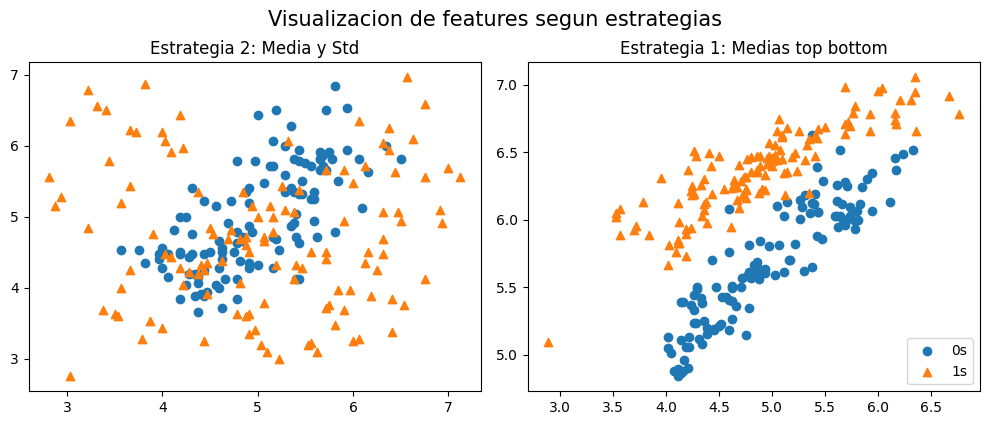

In [ ]:
plt.figure(figsize=(10, 4), facecolor='white')
plt.suptitle('Visualizacion de features segun estrategias',
             y=1.05, fontsize=15)
for idx, data in enumerate(p_transf_data):
  X_tranf = data[0]
  fig_index = idx + 1
  plt.subplot(1, 2, idx+1)
  if fig_index == 1:
      plt.title('Estrategia 2: Media y Std')
  elif fig_index == 2:
      plt.title('Estrategia 1: Medias top bottom')

  plt.scatter(X_tranf[y_bin_train == 0, 0],
              X_tranf[y_bin_train == 0, 1],
              marker='o',
              label='0s')
  plt.scatter(X_tranf[y_bin_train == 1, 0],
              X_tranf[y_bin_train == 1, 1],
              marker='^',
              label='1s')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.legend(loc='lower right')
plt.show()

# Complicando las cosas


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

In [ ]:
p_transf_data_10 = []

for func, title in zip(p_functions, p_titles):
  # Definimos un pereceptrón
  clf = Perceptron(tol=1e-3, random_state=0)

  # Transformamos las features de los datos para el problema binario
  X_train_features = func(X_train)
  X_test_features = func(X_test)
  p_transf_data_10.append((X_train_features, X_test_features))

  # Entrenamos el clasificador
  clf.fit(X_train_features, y_train)

  print("Con la estrategia:", title, "se obtiene:\n")
  # Imprimir la accuracy en los datos de test.
  print("\t Accuracy en test: " + str(clf.score(X_test_features,
                                             y_test)))
  print()
  # Imprimir las predicciones realizadas para los datos de test
  print("Predicciones: \n" + str(clf.predict(X_test_features)))
  print()

Con la estrategia: Mean and Std se obtiene:

	 Accuracy en test: 0.16666666666666666

Predicciones: 
[4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 6 8 8 6 8 6 8 4 4 8 8 8
 8 8 6 6 8 8 8 6 8 8 8 6 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 4 8 8 8 8 8 8 8 8 8 4 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 8 8 8 8 8 8 6 8 8 6 8
 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 6 8 8 8 8 8
 8 8 8 8 6 8 8 8 8 6 8 8 8 4 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8
 8 6 8 8 8 8 8 8 8 4 8 8 8 8 6 8 8 6 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8
 8 8 4 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 6 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 6 8 8 8 8 8 8 8

Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

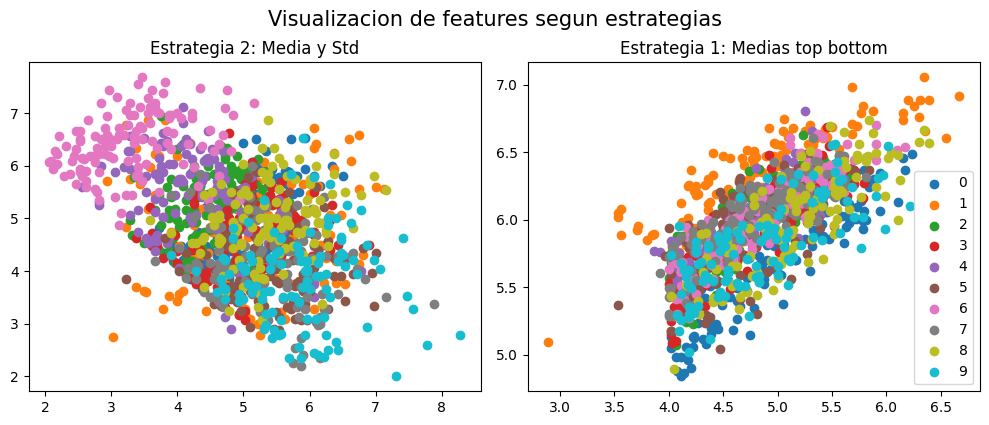

In [ ]:
plt.figure(figsize=(10, 4), facecolor='white')
plt.suptitle('Visualizacion de features segun estrategias',
             y=1.05, fontsize=15)
for idx, data in enumerate(p_transf_data_10):
  X_tranf = data[0]
  fig_index = idx + 1
  plt.subplot(1, 2, idx+1)
  if fig_index == 1:
      plt.title('Estrategia 2: Media y Std')
  elif fig_index == 2:
      plt.title('Estrategia 1: Medias top bottom')
  n_classes =  np.unique(y_train)
  for cl in n_classes:
    plt.scatter(X_tranf[y_train == cl, 0],
                X_tranf[y_train == cl, 1],
                marker='o',
                label=str(cl))
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.legend(loc='lower right')
plt.show()

# Entregable:

Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos?

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuestas:

1. Para el caso binario, la estrategia Medias top bottom (Estrategia 1) funcionó mejor que la estrategia Media y Std (Estrategia 2). Como puede verse en las visualizaciones la primera estrategia logra una buena separación lineal entre las dos clases, mientras que la segunda estrategia muestra que no hay tal separación. Para el caso multiclase las dos estrategias funcionaron en forma similar.
2. Para el caso binario si las clases estan balanceadas, esto significa que tenemos 50 % de cada clase. Si un algoritmo predice aleatoriamente las clases, cada predicción tiene una probabilidad del 0.5 de ser correcta. Por lo tanto la accurracy esperada de este algoritmo aleatorio sería del 50 %, ya que acertaria la mitad de las veces. Por otro lado, si se tiene un dataset balanceado de digitos del 0 al 9, siginifica que cada una de las 10 clases tiene la misma cantidad de ejemplo y representa el 10 % del total. Luego con un razonamiento similiar la accuracy esperada serìa del 10 %.
3. Notemos que el clasificador diseñado para el caso binario funciona mucho mejor que uno aleatorio usando la estrategia 1 (acc 0.83) y casi igual que uno aleatorio con la estrategia 2 (acc 0.54). Para el problema multiclase con ambas estrategias los clasificadores funcionan similar a un clasificador aleatorio (acc 0.17, acc 0.14).  

